In [27]:
import numpy as np 
import torch
from pytorch3d.io import load_objs_as_meshes
from pytorch3d.structures import Meshes, Pointclouds
from pytorch3d.ops import sample_points_from_meshes
from pytorch3d.renderer import FoVPerspectiveCameras
from pytorch3d.renderer import (
    AlphaCompositor,
    PointsRasterizationSettings,
    PointsRenderer,
    PointsRasterizer,
    look_at_view_transform
)
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")


## Chuyển về file pointclouds

In [28]:
mesh = load_objs_as_meshes(["data/cow.obj"], device)
points, normals, textures = sample_points_from_meshes(mesh, num_samples=50000, return_normals= True, return_textures= True)  # [1, N, 3] return samples, normal, textures 
# pytorch3d cập nhật việc lấy PointClouds phải gồm có samples, normals và features (textures)
# samples có shape là (1 x N x 3) trong đó (batch, số điểm, xyz)

points_np   = points[0].cpu().numpy()   # (N, 3)
normals_np  = normals[0].cpu().numpy()  # (N, 3)
colors_np   = textures[0].cpu().numpy() # (N, 3), giá trị trong [0, 1]

# Lưu vào file .npz
np.savez("data/cow_pointcloud.npz",
         verts=points_np,
         normals=normals_np,
         rgb=colors_np)


## Render thử file vừa lưu

In [32]:
cow_pc = np.load("data/cow_pointcloud.npz")
points_new = torch.tensor(cow_pc["verts"], dtype=torch.float32).unsqueeze(0).to(device)
textures_new = torch.tensor(cow_pc["rgb"], dtype=torch.float32).unsqueeze(0).to(device)
point_clouds = Pointclouds(points= points_new, features= textures_new)
#Setting camera
R, T = look_at_view_transform(dist = 3.0, elev= 0.0, azim= 180)
cameras = FoVPerspectiveCameras(R=R, T=T, device=device)
#Setting cho rasterizer
raster_settings = PointsRasterizationSettings(image_size=512, radius=0.03,)
rasterizer = PointsRasterizer(raster_settings= raster_settings)
compositor = AlphaCompositor(background_color= [1.0,1.0,1.0])

#Khởi tạo render
renderer = PointsRenderer(rasterizer= rasterizer, compositor= compositor)

images = renderer(point_clouds, cameras= cameras)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000001].


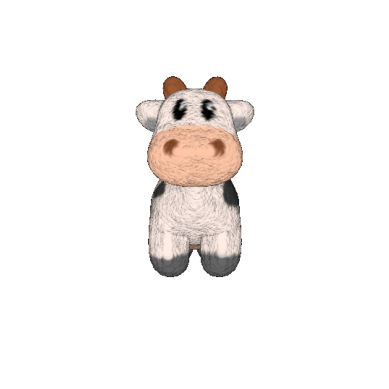

In [36]:
import matplotlib.pyplot as plt 
import imageio
image = images.cpu().numpy()[0, ..., :3]
plt.imshow(image)
plt.axis("off")
plt.show()
imageio.imwrite("output/cow_from_pclds.png", (image * 255).astype(np.uint8))